## 4\. Apresentação

A **etapa de apresentação** é responsável por disponibilizar os dados aos utilizadores (analistas, cientistas de dados, etc.) e sistemas (dashboards, motores de consultas, entre outros), preferencialmente através de uma interface simples, como o SQL. Esta é a única fase à qual a maioria dos utilizadores terá acesso. Além disso, é crucial que as ferramentas usadas nesta fase entreguem dados provenientes de camadas refinadas da arquitetura, garantindo consultas mais eficientes e dados consistentes.

### **4.1. AWS Athena**

Nesta etapa, o` AWS Athena` desempenha o papel de disponibilizar os dados aos utilizadores por meio de uma interface SQL. Para configurar essa interface, é necessário criar uma tabela externa sobre os dados armazenados na camada mais refinada da arquitetura, chamada **camada enriquecida**.

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://m42-ebac-enriched/telegram/'
```

Após isso, é necessário adicionar as partições disponíveis aos dados.

> **Nota Importante:** Sempre que uma nova partição é adicionada ao repositório de dados, é fundamental informar o `AWS Athena` para que ela esteja disponível nas consultas SQL. Para isso, pode-se utilizar o comando SQL `MSCK REPAIR TABLE <nome-tabela>` para atualizar todas as partições (processo mais caro) ou o comando `ALTER TABLE <nome-tabela> ADD PARTITION <coluna-partição> = <valor-partição>` para adicionar uma partição específica (processo mais económico). Pode consultar a documentação neste [link](https://docs.aws.amazon.com/athena/latest/ug/alter-table-add-partition.html)).

```sql
MSCK REPAIR TABLE `telegram`;
```

Execução da consulta para retornar as primeiras 10 linhas da tabela.

```sql
SELECT * FROM "default"."telegram" limit 10;
```

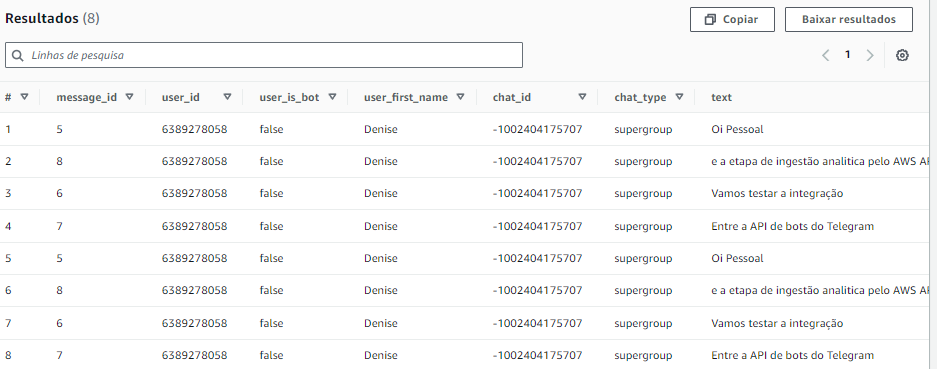

### **4.2. Analytics**

Com o dado disponível, usuário podem executar as mais variadas consultas analíticas. Seguem alguns exemplos:

- Quantidade de mensagens por dia.

```sql
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```

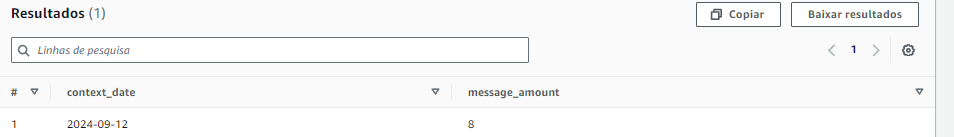

- Quantidade de mensagens por usuário por dia.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

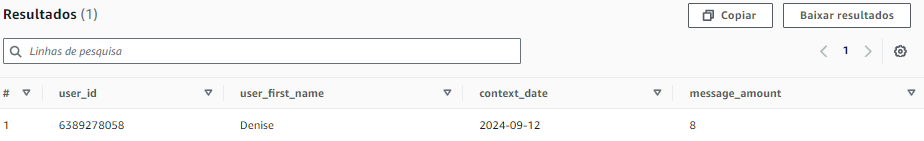

- Média do tamanho das mensagens por usuário por dia.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

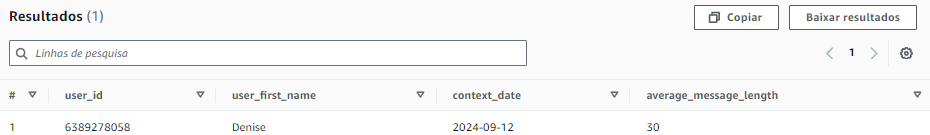

- Quantidade de mensagens por hora por dia da semana por número da semana.

```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

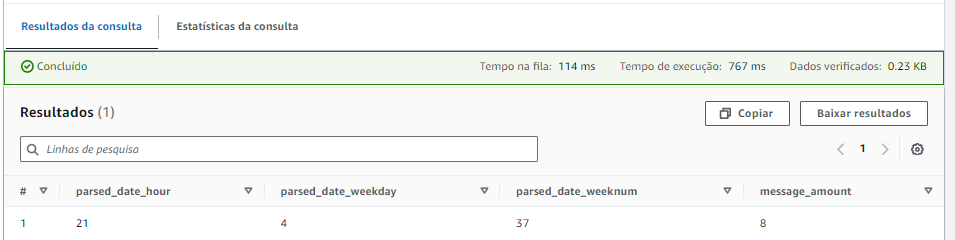

# Conclusão


  Este projeto demonstra a importância de criar um pipeline eficiente para capturar e analisar grandes volumes de mensagens de um grupo no **Telegram**, integrando essa fonte de dados a uma infraestrutura robusta como a `AWS`. Através da utilização de serviços como `AWS Lambda`, `S3`, `Athena` e `EventBridge`, foi possível construir uma **solução escalável** que permite não só o armazenamento eficiente das mensagens em tempo real, mas também a sua transformação e disponibilização para análises avançadas.



Um dos grandes benefícios desse sistema é a sua **capacidade de lidar com altos volumes de dados de forma automática**, garantindo que as mensagens estejam sempre prontas para **consulta e análise** com o **mínimo de intervenção manual**. Isso é particularmente útil em cenários onde se pretende acompanhar o comportamento de utilizadores em **comunidades online**, **monitorar feedback em tempo real** ou realizar **estudos de padrões de comunicação**, que podem oferecer *insights* valiosos para diferentes áreas.



Por exemplo, este tipo de pipeline pode ser inserido em cenários como:

- **Monitorização de redes sociais e comunicação interna em empresas:** Empresas podem utilizar esse pipeline para monitorar interações em grupos de trabalho, analisando o volume de mensagens, o engajamento dos membros e a eficiência da comunicação interna.

- **Análise de feedback de clientes:** Equipas de atendimento ao cliente podem usar essa solução para capturar e analisar o feedback dado em grupos de suporte, extraindo insights sobre a satisfação dos clientes e áreas de melhoria nos produtos ou serviços oferecidos.

- **Estudos de comportamento e comunicação:** Pesquisadores podem aplicar essa abordagem para identificar padrões de comportamento, como os horários mais comuns de atividade, a duração média das interações, ou as palavras mais utilizadas em discussões.



Ao permitir a análise detalhada de um grande volume de mensagens, o poder desta solução reside na sua capacidade de fornecer insights valiosos, como a **identificação de tendências e padrões** que, de outra forma, poderiam passar despercebidos. Através de consultas `SQL` no `AWS Athena`, é possível identificar, por exemplo, **picos de atividade**, os **utilizadores mais ativos**, e até mesmo a **evolução do conteúdo das mensagens ao longo do tempo**.




Em resumo, este projeto não só simplifica o processo de captura e armazenamento de mensagens, mas também proporciona uma forma poderosa de extrair *insights* que podem ser aplicados em diversas áreas, desde marketing e comunicação até pesquisa e desenvolvimento de produtos.
